In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import seaborn as sns
from scipy.stats import zscore, norm, spearmanr, pearsonr, ttest_ind
from datetime import datetime, timedelta
from itertools import product
import geopy.distance
from itertools import islice
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from pyod.models.mad import MAD

In [0]:
if datetime.today().weekday()+1!=1:
  exit 
else:
  params={}
  params['global_start']=datetime.strftime(datetime.today()-timedelta(7),format='%Y-%m-%d')
  params['global_end']=datetime.strftime(datetime.today()-timedelta(1),format='%Y-%m-%d')

  params['global_start_ly']=datetime.strftime(datetime.today()-timedelta(7+364),format='%Y-%m-%d')
  params['global_end_ly']=datetime.strftime(datetime.today()-timedelta(1+364),format='%Y-%m-%d')

  params['subq']=""" select * from delta.`/mnt/datalake/data/gold/DepartmentUnitsInfo` where businessid='DodoPizza' """

  query="""
  select 
  b.countryid, 'ty' as period, unitid,  
  count(distinct orderid) as tickets, sum(cast(producttotalprice as float)) as rto, count(*) as qty, sum(cast(menuprice as float)) as rto_do
  from
  (select * from delta.`/mnt/datalake/data/gold/OrderCompositionExtendedWithCombo`
  where 
  categoryid>0 and date>='{global_start}' and date<='{global_end}' and businessid='DodoPizza' and categoryid!=5) a
    inner join ({subq}) b on a.unituuid=b.uuid
  group by
  b.countryid, unitid

  union all

  select 
  b.countryid, 'ly' as period, unitid, 
  count(distinct orderid) as tickets, sum(cast(producttotalprice as float)) as rto, count(*) as qty, sum(cast(menuprice as float)) as rto_do
  from
  (select * from delta.`/mnt/datalake/data/gold/OrderCompositionExtendedWithCombo`
  where 
  categoryid>0 and date>='{global_start_ly}' and date<='{global_end_ly}' and businessid='DodoPizza'and categoryid!=5) a 
    inner join ({subq}) b on a.unituuid=b.uuid
  group by
  b.countryid, unitid""".format(**params)
  df_lfl=spark.sql(query).toPandas()


  df_lfl=pd.merge(df_lfl.groupby(['countryid','unitid'])[['period']].count().query('period==2').reset_index().iloc[:,:2],
          df_lfl,
          how='inner',
          on=['countryid','unitid']
  )

  df_lfl_ty=df_lfl.query('period=="ty"').drop('period', axis='columns')
  df_lfl_ly=df_lfl.query('period=="ly"').drop('period', axis='columns')

  df_lfl=pd.merge(df_lfl_ty, df_lfl_ly, how='inner', on=['countryid','unitid'], suffixes=('_ty','_ly'))

  df_lfl=df_lfl.groupby('countryid', as_index=False).agg('sum').drop('unitid',axis='columns')

  for i in ['_ty','_ly']:
    df_lfl['avg_price_do'+i]=df_lfl['rto_do'+i]/df_lfl['qty'+i]
    df_lfl['complexity'+i]=df_lfl['qty'+i]/df_lfl['tickets'+i]
    df_lfl['discount'+i]=(df_lfl['rto_do'+i]-df_lfl['rto'+i])/df_lfl['rto_do'+i]


  query="""
  select 
  b.countryid, 'ty' as period, unitid, productid, count(*) as qty, sum(cast(menuprice as float)) as rto_do
  from
  (select * from delta.`/mnt/datalake/data/gold/OrderCompositionExtendedWithCombo`
  where categoryid>0 and date>='{global_start}' and date<='{global_end}' and incombo=0 and businessid='DodoPizza' and categoryid!=5) a inner join ({subq}) b on a.unituuid=b.uuid
  group by
  b.countryid, unitid, productid

  union all

  select 
  b.countryid, 'ly' as period, unitid, productid, count(*) as qty, sum(cast(menuprice as float)) as rto_do
  from
  (select * from delta.`/mnt/datalake/data/gold/OrderCompositionExtendedWithCombo`
  where categoryid>0 and date>='{global_start_ly}' and date<='{global_end_ly}' and incombo=0 and businessid='DodoPizza' and categoryid!=5) a inner join ({subq}) b on a.unituuid=b.uuid
  group by
  b.countryid, unitid, productid""".format(**params)
  df_infl=spark.sql(query).toPandas()

  df_infl=pd.merge(df_infl.groupby(['countryid','unitid'])[['period']].nunique().query('period==2').reset_index().iloc[:,:2],
          df_infl,
          how='inner',
          on=['countryid','unitid']
  )

  df_infl=df_infl.groupby(['countryid','period','productid'], as_index=False).agg({'qty':'sum','rto_do':'sum'})

  df_infl=pd.merge(df_infl.query('period=="ty"').drop('period',axis='columns'), 
          df_infl.query('period=="ly"').drop('period',axis='columns'),
          how='inner',
          on=['countryid','productid'],
          suffixes=('_ty','_ly')
          )


  df_infl['price_ly']=df_infl['rto_do_ly']/df_infl['qty_ly']
  df_infl['rto_do_ty_to_be']=df_infl['price_ly']*df_infl['qty_ty']

  df_infl=pd.DataFrame(df_infl.groupby('countryid')[['rto_do_ty','rto_do_ty_to_be']].sum().apply(lambda x: x['rto_do_ty']/x['rto_do_ty_to_be']-1, axis=1), columns=['inflation'])

  df_lfl=pd.merge(df_lfl, df_infl.reset_index(), how='inner', on='countryid')

  df_lfl['price_do_chg']=df_lfl['avg_price_do_ty']/df_lfl['avg_price_do_ly']-1
  df_lfl['mix']=(1+df_lfl['price_do_chg'])/(1+df_lfl['inflation'])-1
  df_lfl['rto_lfl_chg_as_is']=df_lfl['rto_ty']/df_lfl['rto_ly']-1


  bl=df_lfl['rto_ly']
  df_lfl['tickets_impact']=df_lfl['rto_lfl_chg_as_is']-\
            ((df_lfl['tickets_ly']*df_lfl['complexity_ty']*df_lfl['avg_price_do_ly']*(1+df_lfl['inflation'])*(1+df_lfl['mix'])*(1-df_lfl['discount_ty']))/bl-1)


  df_lfl['complexity_impact']=df_lfl['rto_lfl_chg_as_is']-\
            ((df_lfl['tickets_ty']*df_lfl['complexity_ly']*df_lfl['avg_price_do_ly']*(1+df_lfl['inflation'])*(1+df_lfl['mix'])*(1-df_lfl['discount_ty']))/bl-1)
    

  df_lfl['inflation_impact']=df_lfl['rto_lfl_chg_as_is']-\
            ((df_lfl['tickets_ty']*df_lfl['complexity_ty']*df_lfl['avg_price_do_ly']*(1+df_lfl['mix'])*(1-df_lfl['discount_ty']))/bl-1)
    

  df_lfl['mix_impact']=df_lfl['rto_lfl_chg_as_is']-\
            ((df_lfl['tickets_ty']*df_lfl['complexity_ty']*df_lfl['avg_price_do_ly']*(1+df_lfl['inflation'])*(1-df_lfl['discount_ty']))/bl-1)
    

  df_lfl['discount_impact']=df_lfl['rto_lfl_chg_as_is']-\
            ((df_lfl['tickets_ty']*df_lfl['complexity_ty']*df_lfl['avg_price_do_ly']*(1+df_lfl['inflation'])*(1+df_lfl['mix'])*(1-df_lfl['discount_ly']))/bl-1)

/home/spark-bc5042f2-4e77-458e-a958-ec/.ipykernel/2174/command-1286657205067228-1739060128:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


Text(0, 1.01, 'Week LY: 2022-10-23...2022-10-29')

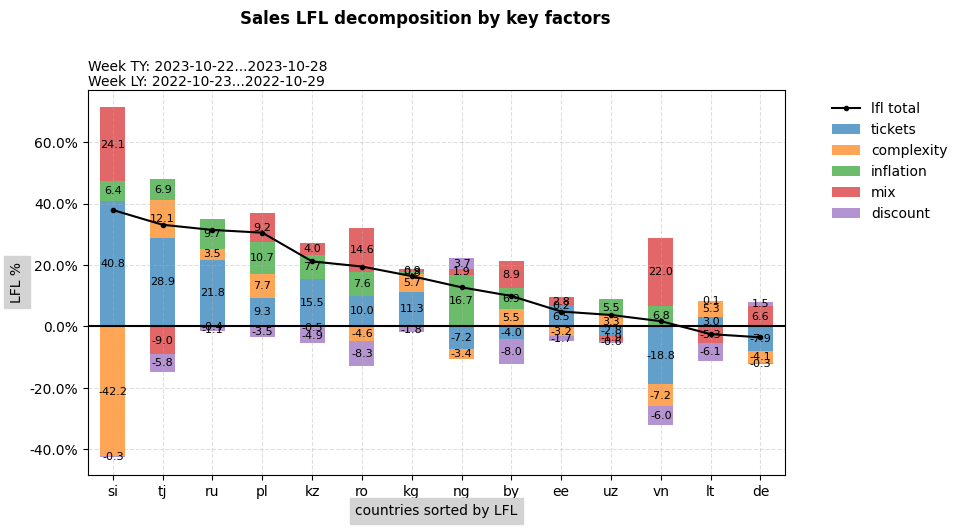

In [0]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(9,5))
fig.suptitle('Sales LFL decomposition by key factors', y=1.04, fontweight='bold')

df_temp=df_lfl.set_index('countryid').sort_values(by='rto_lfl_chg_as_is', ascending=False).iloc[:, -5:]
df_temp.columns=[x.replace('_impact','') for x in df_temp.columns]
df_temp.plot(kind='bar', stacked=True, ax=ax, alpha=0.7)

for c in ax.containers:
    labels = [np.round(v.get_height()*100,1) for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=8)


df_lfl.set_index('countryid').sort_values(by='rto_lfl_chg_as_is', ascending=False).rename(columns={'rto_lfl_chg_as_is':'lfl total'})['lfl total'].plot(ax=ax, marker='.', color='black')
ax.axhline(0, color='black')
ax.grid(linestyle='--', alpha=0.4)

ax.set_xlabel('countries sorted by LFL', backgroundcolor='lightgrey')
ax.set_ylabel('LFL %', backgroundcolor='lightgrey')

ax.legend(bbox_to_anchor=(1.25,1), frameon=False)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

ax.tick_params(axis='x', labelrotation = 0)

ax.text(x=0, y=1.05, s='Week TY: '+params['global_start']+'...'+params['global_end'], transform=ax.transAxes)
ax.text(x=0, y=1.01, s='Week LY: '+params['global_start_ly']+'...'+params['global_end_ly'], transform=ax.transAxes)

In [0]:
fig.savefig(fname= "/Workspace/Repos/a.tarasov@dodopizza.com/analytic_images/output_images.jpg", bbox_inches='tight')

In [0]:
message1 = "![Данные за прошлую неделю](https://github.com/alextarasov90/analytic_images/blob/main/output_images.jpg?raw=true)"

In [0]:
def main():
    # Specify Mattermost webhook url to send message
    url = "https://dodobrands.loop.ru/hooks/fsic3xmaq7rhfrfd13hmfrs9ha"

    # Create message payload per mattrermost API documentation:
    # https://docs.mattermost.com/developer/webhooks-incoming.html#parameters-and-formatting
    messages = [
        {
             'username': 'CVM cat',
             'icon_url': 'https://i.ibb.co/LQMSBCh/udivl-nnaya-morda-malenkogo-kotenka.jpg',
             'text'    : message1
             
             
        }
        
    ]

    # Post above messages!
    for message in messages:
        post_to_mattermost(url, json.dumps(message))

def post_to_mattermost(url, message):
    # Send payload as HTTP Post Request to Webhook URL
    r = requests.post(
        url,
        data=message
    )
    r.raise_for_status()

if (__name__) == '__main__':
    main()